In [2]:
import numpy as np
from matplotlib import pyplot as plt
import netCDF4 as nc
import datetime
from matplotlib.animation import FuncAnimation as FA
import rasterio as rio
from matplotlib import colors

In [3]:
# state matrix
#   states: 0 - no fuel
#          -1 - burned
#           1 - has fuel, burning, spreading
#           2 - has fuel, burning, not spreading
#           3 - has fuel, not burning, not spreading
# list of pixels with state 1 (we only care about these and their neighbors)
# list of pixels with state 0 (convenient to ignore these, useful for representation)

In [24]:
# give me all the coordinates currently in state
def get_state(state_mtx,state):
    coords = np.argwhere(state_mtx==state)
    return set([tuple(x) for x in coords])

# take in a coordinate (tuple) and return a set of coordinates adjacent
def get_adjacent(pixel):
    neighbors = set()
    i,j = pixel
    
    candidates = [(y,x) for y in range(i-1,i+2) for x in range(j-1,j+2)]
    
    for neighbor in candidates:
        if (0 <= neighbor[0] < m) and (0 <= neighbor[1] < n) and (state_mtx[neighbor] == 3) and (neighbor != pixel):
            neighbors.add(neighbor)
            
    return neighbors

# take in a coordinate (tuple) and return a set of coordinates downwind
def get_downwind(pixel):
    neighbors = set()
    i,j = pixel
    
    r = round(wind_spd[pixel]/50*1609/spatial_resolution) + reach_augment
    wd = wind_dir[pixel]
    if np.isnan(wd):
        r = 0
    
    candidates = [(y,x) for y in range(i-1-r,i+2+r) for x in range(j-1-r,j+2+r)]
    
    for neighbor in candidates:
        # theta is the direction from the current pixel to the neighbor
        theta = np.arctan2(pixel[0]-neighbor[0],neighbor[1]-pixel[1])
        if theta <= 0: theta += 2*np.pi
        diff = wd - theta
        if (np.abs(diff) < downwind_arc) and (0 <= neighbor[0] < m) and (0 <= neighbor[1] < n) and\
            (state_mtx[neighbor] == 3) and (r*2**(-diff/downwind_arc*2) <= np.linalg.norm(np.subtract(pixel,neighbor))):
            neighbors.add(neighbor)
    
    return neighbors

# take in a coordinate (tuple) and a probability and adjust the ignition matrix
def burn(pixel, p):
    global ign_mtx, state_mtx, copy_mtx
    ign_mtx[pixel] += p
    if ign_mtx[pixel] >= ign_threshold:
        state_mtx[pixel] = 2
        copy_mtx[pixel] = 2

In [45]:
# constants
ign_threshold = 1
spatial_resolution = 250
dsdt = int(3000//spatial_resolution)*4
reach_augment = 3
downwind_arc = 30
veg_dens_threshold = 0.2

## real data

In [46]:
global copy_mtx, state_mtx, prob_mtx, ign_mtx, wind_dir, wind_mag, wind_gust

# load ignition probability dataset
pnc = nc.Dataset('/mnt/mordor3/data/VIIRS/raster_data/riceridge/fire_prob_201706-201708_250m.nc')
prob_cube = pnc['fire_prob'][53:]
t,m,n = prob_cube.shape
prob_mtx = prob_cube[0]

# load VIIRS dataset for comparison
vnc = nc.Dataset('/mnt/mordor3/data/VIIRS/raster_data/riceridge/viirs_riceridge_250m.nc')
viirs_cube = vnc['VIIRS_FRP']

# topography
dem = rio.open('/mnt/mordor3/data/VIIRS/raster_data/riceridge/elevation_250m_wgs.tif').read()[0]

# old weather
#wind_csv = np.loadtxt('/mnt/mordor3/data/VIIRS/seeley_raws_06012017-08312017.csv',skiprows=1, usecols=[2,3,4])
#wind_dir_arr = wind_csv[53:,1]
#wind_mag_arr = wind_csv[53:,0]
#wind_gust_arr = wind_csv[53:,2]
#wind_dir = wind_dir_arr[0]
#wind_mag = wind_mag_arr[0]
#wind_gust = wind_gust_arr[0]

# new weather
wdir = rio.open('/mnt/mordor3/data/VIIRS/raster_data/riceridge/rtma_hourly_wdir_250m.tif').read()
wdir[wdir<0] = np.nan
wdir = (90-wdir)*np.pi/180
wind_dir = wdir[0]
wspd = rio.open('/mnt/mordor3/data/VIIRS/raster_data/riceridge/rtma_hourly_wspd_250m.tif').read()
wspd[wspd<0] = 0
wind_spd = wspd[0]


# initialize state with vegetation patches and ignition point
# initial state is based on forest density and ignition lat lon
veg_mtx = rio.open('/mnt/mordor3/data/VIIRS/vegetation_riceridge_2016_250m.tif').read()/100
col = np.argmin(np.abs(pnc.variables["longitude"][:] + 113.457))
row = np.argmin(np.abs(pnc.variables["latitude"][:] - 47.212))
ign_loc = (row,col)
state_mtx = (veg_mtx[5]>veg_dens_threshold)*3
state_mtx[ign_loc] = 2

# make the copy matrix that will be used throughout
copy_mtx = np.zeros_like(state_mtx)
copy_mtx[:] = state_mtx

ign_mtx = np.zeros_like(state_mtx)

## Run the CA

In [47]:
# combine wind direction and slope to get direction of maximum spread
# use direction and rate of spread to get neighborhood
# use spread rate and burn probability to influence fire growth
# use vegetation distribution to impact burn probability and rate of spread
# rate of spread and subdaily timestepping

In [50]:
def update(i):
    global tp, copy_mtx, state_mtx, prob_mtx, wind_dir, wind_mag, wind_gust
    
    # consider cells in states 1 and 2. cells in state 1 can ignite cells which are adjacent,
    # and cells which are in states 1 or 2 can ignite cells which are downwind. 
    # let us maintain an ignition matrix, which will accumulate 'spread' from burning cells which
    # reach each cell. then if any cell in the ignition matrix exceeds a threshold, transition that
    # cell in the state matrix from 3 to 2. so:
    #
    # get all cells which are in state 1 and all cells which are in state 2
    # iterate over state 1 cells:
    #     copy matrix gets updated state (1 -> 0)
    #     get adjacent and downwind cells from state matrix which have state 3
    #     ignition matrix gets spread in adjacent and downwind cells
    #     if ignition threshold is reached, copy matrix and state matrix get updated state (3 -> 2)
    # iterate over state 2 cells:
    #     copy matrix gets updated state (2 -?> 1)
    #     get downwind cells from state matrix which have state 3
    #     ignition matrix gets spread in downwind cells
    #     if ignition threshold is reached, copy matrix and state matrix get updated state (3 -> 2)
    
    def prob_slope(pixel,neighbor):
        height = dem[neighbor] - e_pixel
        if ~np.isnan(height):
            d = np.linalg.norm(np.subtract(neighbor,pixel))
            p_slope = height/(d*spatial_resolution)/d
        else:
            p_slope = -100
        return p_slope
    
    spreading = get_state(state_mtx,1)
    burning = get_state(state_mtx,2)
    
    for pixel in spreading:
        p_pixel = prob_mtx[pixel]
        e_pixel = dem[pixel]
        w_pixel = wind_spd[pixel]
        copy_mtx[pixel] = -1
        
        adjacent = get_adjacent(pixel)
        for neighbor in adjacent:
            p_slope = prob_slope(pixel, neighbor)
            p = prob_mtx[neighbor] + p_slope
            burn(neighbor, p)
        
        downwind = get_downwind(pixel)
        for neighbor in downwind:
            p_neighbor = prob_mtx[neighbor]
            p_slope = prob_slope(pixel, neighbor)
            p_wind = (w_pixel + wind_spd[neighbor])/20
            p = p_pixel + p_neighbor + p_slope*p_wind
            burn(neighbor, p)
    
    for pixel in burning:
        e_pixel = dem[pixel]
        w_pixel = wind_spd[pixel]
        p_pixel = prob_mtx[pixel]
        if np.random.rand() <= p_pixel/dsdt*10:
            copy_mtx[pixel] = 1
        
        downwind = get_downwind(pixel)
        for neighbor in downwind:
            p_neighbor = prob_mtx[neighbor]
            p_slope = prob_slope(pixel, neighbor)
            p_wind = (w_pixel + wind_spd[neighbor])/20
            p = p_pixel + p_neighbor + p_slope*p_wind
            burn(neighbor, p)
    
    state_mtx[:] = copy_mtx
    
    if i%int(dsdt/24) == 0:
        j = int(i//(dsdt/24))
        wind_dir = wdir[j]
        wind_speed = wspd[j]
    
    if i%dsdt == 0:
        k = int(i//dsdt)
        ti = datetime.datetime.now()
        fig.suptitle(f'day {k}\n time elapsed: {ti-t0}\n this iteration: {ti-tp}\n spreading: {len(get_state(state_mtx,1))}\n burning: {len(get_state(state_mtx,2))}')
        tp = ti
        prob_mtx = prob_cube[k]
        ax[0].imshow(state_mtx, cmap=cmap, norm=norm, interpolation='none')
        ax[1].imshow(viirs_cube[k])

MovieWriter ffmpeg unavailable; using Pillow instead.


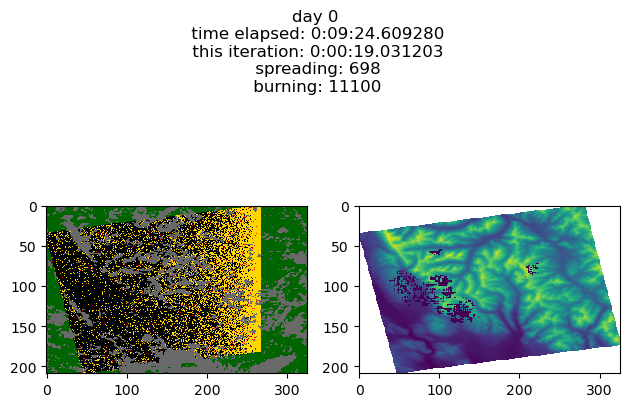

In [49]:
global tp, ax

state_mtx = (veg_mtx[5]>veg_dens_threshold)*3
state_mtx[ign_loc] = 2
copy_mtx = np.zeros_like(state_mtx)
copy_mtx[:] = state_mtx
ign_mtx = np.zeros_like(state_mtx)

t0 = datetime.datetime.now()
tp = t0

cmap = colors.ListedColormap(['black', 'dimgray', 'red', 'gold', 'darkgreen'])
bounds=[-1,0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig,ax = plt.subplots(1,2,layout='tight')
ax[0].imshow(state_mtx, cmap=cmap, norm=norm, interpolation='none')
ax[1].imshow(dem)
ax[1].imshow(viirs_cube[0])

anim = FA(fig, update, frames=range(0,t*dsdt,dsdt), repeat=False)
anim.save('/home/adam.viray/Documents/CA/CA_250m.gif')